In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from torchvision import transforms
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, QuantileTransformer

In [72]:
meta_data = pd.read_csv('cluster_meta.csv')
print(meta_data.head())

def load_data(folder_path,meta_data):
    data = []
    for file in meta_data['cluster']:
        file = file + '.csv'
        file_path = os.path.join(folder_path,file)
        cluster = pd.read_csv(file_path,header=None).values
        cluster = cluster.flatten()
        # cluster = np.append(cluster, meta_data[meta_data['cluster'] == file[:-4]][['y', 'x', 'E', 'size']].values.flatten())
        data.append(cluster)
    combined_array = np.stack(data,axis=0)
    print('shape of combined array: ')
    print(combined_array.shape)
    return combined_array, meta_data[['y', 'x', 'E', 'size']].values


meta_scaler = RobustScaler()
meta_data_values = meta_scaler.fit_transform(meta_data[['y', 'x', 'E', 'size']])
print(meta_data.head())

   Unnamed: 0   cluster     y     x          E   size
0           0  004580_A   9.0  26.0   715232.0  108.0
1           1  011701_G  15.0  17.0  1184202.0  179.0
2           2  003882_A   3.0   3.0    31156.0    6.0
3           3  009717_G   7.0  62.0  1423016.0  245.0
4           4  005590_A  32.0  31.0  1014772.0  169.0
   Unnamed: 0   cluster     y     x          E   size
0           0  004580_A   9.0  26.0   715232.0  108.0
1           1  011701_G  15.0  17.0  1184202.0  179.0
2           2  003882_A   3.0   3.0    31156.0    6.0
3           3  009717_G   7.0  62.0  1423016.0  245.0
4           4  005590_A  32.0  31.0  1014772.0  169.0


In [73]:
def import_and_pad_csvs(folder_path):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    data_arrays = []
    number_arrays = len(csv_files)
    number_large = 0
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        data = pd.read_csv(file_path).values
        data_arrays.append(data)
    max_rows = max(array.shape[0] for array in data_arrays)
    max_cols = max(array.shape[1] for array in data_arrays)
    largest_array_index = max(range(len(data_arrays)), key=lambda i: data_arrays[i].shape[0] * data_arrays[i].shape[1])
    print(f"Index of the largest initial array: {largest_array_index}")
    padded_arrays = []
    for array in data_arrays:
        if array.shape[0] <= 64 and array.shape[1] <= 64:
            padded_array = np.zeros((64, 64))
            padded_array[:array.shape[0], :array.shape[1]] = array
            padded_arrays.append(padded_array)
            number_large += 1
    print(f'Number of arrays that are smaller than 64x64: {number_large}, ({number_large/number_arrays*100:.2f}%)')
    print(f'max rows: {max_rows}, max cols:{max_cols}')
    combined_array = np.stack(padded_arrays, axis=0)
    return combined_array

In [87]:
class NumpyArrayDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample  # Return only the sample and dummy label

folder_path = 'clusters_colour_rotations_rescaled'
combined_array, meta_data_values = load_data(folder_path,meta_data)

scaler = QuantileTransformer()
combined_array = scaler.fit_transform(combined_array)
print(combined_array.shape)

meta_data_values = scaler.fit_transform(meta_data_values)

combined_array = np.append(combined_array, meta_data_values, axis=1)


transform = transforms.Compose([
    transforms.ToTensor()
])

combined_array = np.shuffle(combined_array, axis=0)

#meta_data_values = NumpyArrayDataset(meta_data_values, transform=transform)
dataset = NumpyArrayDataset(combined_array, transform=transform)
print(combined_array.shape)

# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# print(meta_data_values.shape)


# train_dataset, test_dataset, train_meta, test_meta = train_test_split(dataset, meta_data_values, test_size=0.2, random_state=42)
# test_dataset = dataset

# lazy, non-random split
test_size = 0.2
split_index = int(len(dataset) * (1 - test_size))
train_dataset = dataset[:split_index]
test_dataset = dataset[split_index:]
train_meta = meta_data_values[:split_index]
test_meta = meta_data_values[split_index:]

shape of combined array: 
(3936, 4096)


In [75]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(train_loader.dataset[0].shape)

#train_meta = DataLoader(train_meta, batch_size=32, shuffle=False)
#test_meta = DataLoader(test_meta, batch_size=32, shuffle=False)

torch.Size([3148, 4100])


In [76]:
combined_array.max()

1.0

1.0


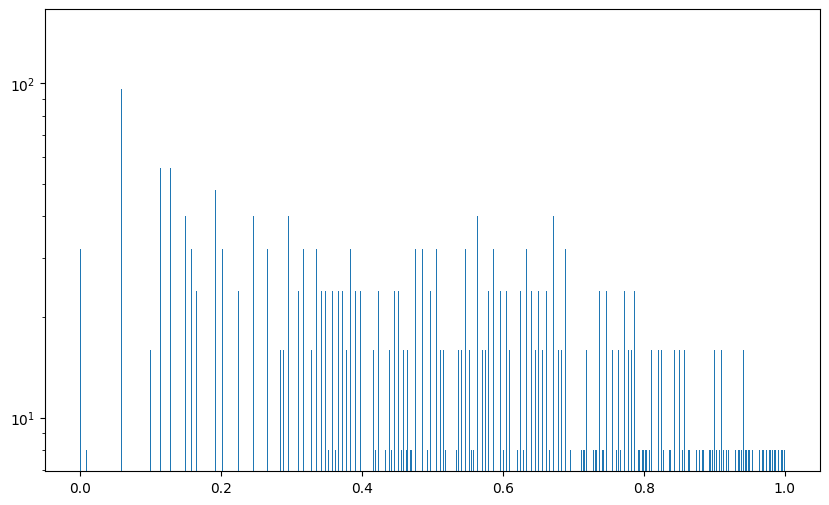

In [77]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(combined_array[:,-1].flatten(), bins=np.linspace(0,1,1000),log=True)
print(np.max(combined_array))


In [78]:
# fig, ax = plt.subplots()
# ax.imshow(combined_array[3929,:,:], cmap='gray')

In [79]:
class Var_Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section:
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),  # 1x256x256 -> 32x128x128
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  # 32x128x128 -> 64x64x64
            nn.ReLU(True),
            nn.MaxPool2d(2, return_indices=True)  # 64x64x64 -> 64x32x32
        )
        
        # Flatten layer
        self.flatten = nn.Flatten(start_dim=0)
 
        # Linear section
        self.encoder_lin_pic = nn.Sequential(
            nn.Linear(65536, 128),
            nn.ReLU(True)
        )

        self.encoder_lin_w_meta = nn.Sequential(
            nn.Linear(128+4, encoded_space_dim),
            nn.ReLU(True)
        )

        ### Variational part
        self.variational_mean = nn.Linear(encoded_space_dim, encoded_space_dim)
        self.variational_var = nn.Linear(encoded_space_dim, encoded_space_dim)

    def reparameterization(self, mean, var):  # Stolen from MNIST example, device must be understood
        epsilon = torch.randn_like(var).cpu() 
        z = mean + var * epsilon
        return z

    def forward(self, x):
        meta = x[-4:]
        x = x[:-4].unflatten(0, (1, 1, 64, 64))
        # print('pass to encoder:', x.shape)
        x, indices = self.encoder_cnn(x)  # Capture indices from MaxPool2d
        # print('encoder output:', x.shape, 'indices', indices.shape)
        x = self.flatten(x)
        # print('flattened:', x.shape, meta.shape)
        x = self.encoder_lin_pic(x)

        y = torch.cat((x, meta), dim=0)
        # print('concatenated:', y.shape)
        x = self.encoder_lin_w_meta(y)
        # print('linear output:', x.shape)
        mean = self.variational_mean(x)
        log_var = self.variational_var(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        return z, mean, log_var, indices

class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super(Decoder, self).__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 65536),  # Update to match your encoder's output
            nn.ReLU(True)
        )
        self.unflatten = nn.Unflatten(dim = 1, unflattened_size=(64, 32, 32))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(True)
        )
        self.unpool = nn.MaxUnpool2d(2)
        self.final_conv = nn.ConvTranspose2d(64, 1, 3, stride=1, padding=1)

    def forward(self, x, indices):
        # print('test0', x.shape, indices.shape)
        x = self.decoder_lin(x).reshape((1,65536))
        # print('test1', x.shape)
        x = self.unflatten(x)
        # print('test2', x.shape)
        x = self.decoder_conv(x)
        # print('test3', x.shape)
        # Here we assume the output size of the unpooling layer, which is the size of the maxpool input
        # output_size = torch.Size([1, 64, 64, 64])
        x = self.unpool(x, indices)#, output_size=output_size)
        x = self.final_conv(x)
        x = torch.sigmoid(x)
        return x

In [80]:
# # print((train_loader.dataset[0][0]))
# x = train_loader.dataset[0][0]
# print(x.shape)
# x = x[:-4].reshape((1,1,64,64))


# # encoder:
# A = nn.Conv2d(1, 32, 3, stride=1, padding=1)
# B = nn.Conv2d(32, 64 , 3, stride=1, padding=1)
# C = nn.MaxPool2d(2)

# # flatten
# D = nn.Flatten()

# # linear
# E = nn.Linear(65536, 128)
# F = nn.Linear(128, 10)

# print(f'original data: {x.shape}')

# print('encoder:')

# print(f'Conv1: {A(x).shape}')
# print(f'Conv2: {B(A(x)).shape}')
# print(f'MaxPool: {C(B(A(x))).shape}')
# print(f'Flatten: {D(C(B(A(x)))).shape}')
# print(f'Linear1: {E(D(C(B(A(x))))).shape}')
# print(f'Linear2: {F(E(D(C(B(A(x)))))).shape}')



# print('decoder:')


# x = train_loader.dataset[0][0]
# x = x[:-4].reshape((1,1,64,64))
# x = F(E(D(C(B(A(x))))))
# # decoder:
# G = nn.Linear(10, 128)
# H = nn.Linear(128, 65536)
# I = nn.Unflatten(dim=1, 
#         unflattened_size=(64, 32, 32))
# J = nn.ConvTranspose2d(64, 64, 3, stride=1,padding = 1)#, output_padding=0)
# # K = nn.BatchNorm2d(64)
# L = nn.ConvTranspose2d(64, 1, 3, stride=1, padding = 1)#, padding=1, output_padding=1)
# # M = nn.BatchNorm2d(8)
# # N = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)

# print(f'Linear1: {G(x).shape}')
# print(f'Linear2: {H(G(x)).shape}')
# print(f'Unflatten: {I(H(G(x))).shape}')
# print(f'Conv1: {J(I(H(G(x)))).shape}')
# print(f'BatchNorm: {K(J(I(H(G(x))))).shape}')
# print(f'Conv2: {L(K(J(I(H(G(x)))))).shape}')

In [81]:
x = train_loader.dataset[0][0]
x = x[:-4].reshape((1, 1, 64, 64))

# Encoder:
A = nn.Conv2d(1, 32, 3, stride=1, padding=1)
B = nn.Conv2d(32, 64, 3, stride=1, padding=1)
C = nn.MaxPool2d(2, return_indices=True)  # Updated to return indices

# Flatten
D = nn.Flatten()

# Linear
E = nn.Linear(65536, 128)
F = nn.Linear(128, 10)

# Encoder forward pass
conv1 = A(x)
conv2 = B(conv1)
maxpool, indices = C(conv2)  # Capture indices for unpooling
# print(indices.shape)
# print(indices)
flattened = D(maxpool)
linear1 = E(flattened)
linear2 = F(linear1)

print(f'original data: {x.shape}')

print('encoder:')
print(f'Conv1: {conv1.shape}')
print(f'Conv2: {conv2.shape}')
print(f'MaxPool: {maxpool.shape}')
print(f'Flatten: {flattened.shape}')
print(f'Linear1: {linear1.shape}')
print(f'Linear2: {linear2.shape}')

# Decoder:
G = nn.Linear(10, 128)
H = nn.Linear(128, 65536)
I = nn.Unflatten(dim=1, unflattened_size=(64, 32, 32))
J = nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1)
K = nn.MaxUnpool2d(2)
L = nn.ConvTranspose2d(64, 1, 3, stride=1, padding=1)

# Decoder forward pass
x = linear2
linear1 = G(x)
linear2 = H(linear1)
unflattened = I(linear2)
conv1_trans = J(unflattened)
unpool = K(conv1_trans, indices)  # Use indices here


print('decoder:')
print(f'Linear1: {linear1.shape}')
print(f'Linear2: {linear2.shape}')
print(f'Unflatten: {unflattened.shape}')
print(f'Conv1: {conv1_trans.shape}')
print(f'MaxUnpool: {unpool.shape}')

conv2_trans = L(unpool)

print(f'Conv2: {conv2_trans.shape}')

original data: torch.Size([1, 1, 64, 64])
encoder:
Conv1: torch.Size([1, 32, 64, 64])
Conv2: torch.Size([1, 64, 64, 64])
MaxPool: torch.Size([1, 64, 32, 32])
Flatten: torch.Size([1, 65536])
Linear1: torch.Size([1, 128])
Linear2: torch.Size([1, 10])
decoder:
Linear1: torch.Size([1, 128])
Linear2: torch.Size([1, 65536])
Unflatten: torch.Size([1, 64, 32, 32])
Conv1: torch.Size([1, 64, 32, 32])
MaxUnpool: torch.Size([1, 64, 64, 64])
Conv2: torch.Size([1, 1, 64, 64])


In [82]:
# Define loss function and training parameters:
def loss_fn(recon_x, x, mean, log_var):
    #MSE = nn.MSELoss()(recon_x, x) 
    BCE = nn.BCELoss(reduction='sum')(recon_x, x)
    KLD = - 0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    #print(MSE, KLD)
    lambda_= 1
    return BCE + lambda_ * KLD

# loss_fn = nn.MSELoss()

lr = 0.01
torch.manual_seed(42)

d = 28
encoder = Var_Encoder(encoded_space_dim=d)
# var_encoder = Var_Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

def train_epoch(encoder, decoder, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch in dataloader.dataset[0]:
        #encoded_data = encoder(image_batch)
        # print('hi')
        encoded_data,mean,var, indices = encoder(image_batch) #VAE
        # print('hello')
        decoded_data = decoder(encoded_data, indices)
        # loss = loss_fn(decoded_data, image_batch[:-4].reshape(decoded_data.shape))
        # print('no error so far')
        # print(image_batch[:-4].reshape(decoded_data.shape))
        loss = loss_fn(decoded_data, image_batch[:-4].reshape(decoded_data.shape),mean,var) #VAE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)


In [83]:
def test_epoch(encoder, decoder, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        mean_out = []
        var_out = []
        for image_batch in dataloader.dataset[0]:
            #encoded_data = encoder(image_batch)
            encoded_data,mean,var, indices = encoder(image_batch) #VAE
            decoded_data = decoder(encoded_data,indices)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch[:-4].reshape(decoded_data.shape).cpu())
            mean_out.append(mean.cpu())
            var_out.append(var.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        mean = torch.cat(mean_out) #VAE
        var = torch.cat(var_out) #VAE
        # val_loss = loss_fn(conc_out, conc_label)
        val_loss = loss_fn(conc_out, conc_label,mean,var) #VAE
    return val_loss.data



In [84]:
import time

In [85]:
diz_loss = {'train_loss': [], 'val_loss': []}

In [86]:
num_epochs = 15
for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train_epoch(encoder, decoder, train_loader, loss_fn, optim)
    val_loss = test_epoch(encoder, decoder, test_loader, loss_fn)
    elapsed_time = time.time() - start_time
    if epoch != 0:
        print(f'Epoch {epoch + 1}/{num_epochs} \t train loss: {train_loss:.2e} \t Delta: {diz_loss['train_loss'][-1]-train_loss:.5e} \t val loss: {val_loss:.5e} \t Delta: {diz_loss['val_loss'][-1]-val_loss:.2e} \t time: {elapsed_time}')
    else:
        print(f'Epoch {epoch + 1}/{num_epochs} \t train loss: {train_loss:.5e} \t val loss: {val_loss:.5e} \t time: {elapsed_time}')
    print(f'Elapsed time: {elapsed_time}')
    diz_loss['train_loss'].append(train_loss)
    diz_loss['val_loss'].append(val_loss)
    #plot_ae_outputs(encoder, decoder, n=10)


Epoch 1/15 	 train loss: 1.77018e+05 	 val loss: 6.07729e+05 	 time: 730.235910654068
Elapsed time: 730.235910654068
Epoch 2/15 	 train loss: 9.08e+02 	 Delta: 1.76110e+05 	 val loss: 6.00501e+05 	 Delta: 7.23e+03 	 time: 992.1826002597809
Elapsed time: 992.1826002597809
Epoch 3/15 	 train loss: 9.24e+02 	 Delta: -1.51145e+01 	 val loss: 6.17173e+05 	 Delta: -1.67e+04 	 time: 1086.2659907341003
Elapsed time: 1086.2659907341003


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
ax.set_yscale('log')
# ax.set_xscale('log')
ax.plot(diz_loss['train_loss'], label='train loss')
# ax.plot(diz_loss['val_loss'], label='val loss')
ax.legend()
# ax.set_xlim(0, 50)


ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
fig.tight_layout()

NameError: name 'plt' is not defined

In [ ]:
encoder.eval()
decoder.eval()

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=28, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1296, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(16, 9, 9))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(16, 16), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 1, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
  )
)

In [ ]:
# sumf = 0
# for i in range(6400):
#     img = test_dataset[i][0].unsqueeze(0).numpy()
#     suming = np.sum(img)
#     if suming>sumf:
#         sumf = sumimg
#         idx = i
# print(i)
# print(sumf)

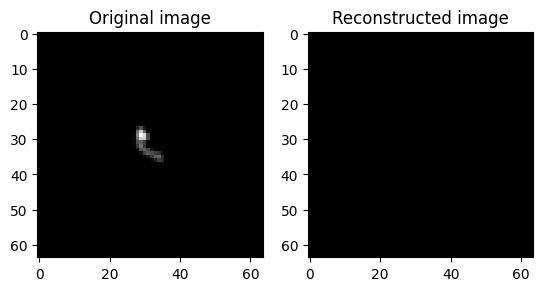

In [ ]:
# evaluate model on radoom image
img = test_dataset[0][3]
with torch.no_grad():
    rec_img = decoder(encoder(img))
    rec_img = rec_img.squeeze().numpy()
    img = img[:-4].squeeze().numpy().reshape(64,64)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original image')
    ax[1].imshow(rec_img, cmap='gray')
    ax[1].set_title('Reconstructed image')

In [ ]:
save = False
if save:
    # Function to save the model
    model_name = '64x64_MinMaxScaler'
    def save_model(encoder, decoder, encoder_path="encoder.pth", decoder_path="decoder.pth"):
        torch.save(encoder.state_dict(), encoder_path)
        torch.save(decoder.state_dict(), decoder_path)
        print("Models saved to {} and {}".format(encoder_path, decoder_path))
    enc = 'training_results/' + model_name + '/encoder.pth'
    dec = 'training_results/' + model_name + '/decoder.pth'
    save_model(encoder, decoder, encoder_path=enc, decoder_path=dec)
    np.savetxt('training_results/' + model_name + '/train_loss.txt', diz_loss['train_loss'])
    np.savetxt('training_results/' + model_name + '/val_loss.txt', diz_loss['val_loss'])

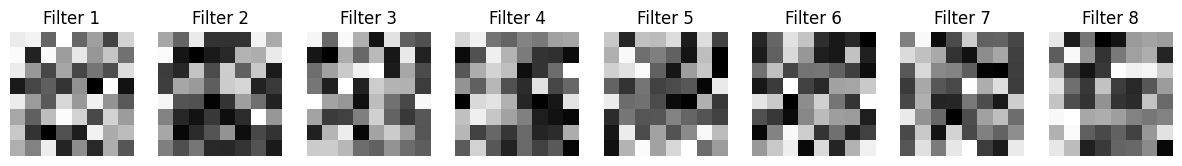

In [ ]:
def plot_initial_convolutions(encoder, num_filters=8, figsize=(15, 15)):
    """
    Plots the initial convolutional filters of the encoder.
    
    Parameters:
    - encoder: The trained encoder model.
    - num_filters: Number of filters to plot. Default is 16.
    - figsize: Size of the plot. Default is (15, 15).
    """
    # Extract the weights from the first convolutional layer
    conv1_weights = encoder.encoder_cnn[0].weight.data.cpu().numpy()
    
    # Create a figure to plot the filters
    fig, axes = plt.subplots(1, num_filters, figsize=figsize)
    
    for i in range(num_filters):
        ax = axes[i]
        # Get the filter
        filt = conv1_weights[i, 0, :, :]
        # Plot the filter
        ax.imshow(filt, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Filter {i+1}')
    
    plt.show()

# Usage example
plot_initial_convolutions(encoder)


In [ ]:
# Function to plot the latent space
